<a href="https://colab.research.google.com/github/mangeshb1/Gen_AI_And_NLP_Experiments/blob/main/Gen_AI_And_Chatbots/LLaMa2_Chat_Text_Personal_Website_Mangesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
__author__ = "Mangesh (MJ) B"
__copyright__ = "Copyright (C) 2024 Mangesh Bhangare"
__version__ = "1.0"

In [ ]:
!nvidia-smi

Sun Feb 11 13:50:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchvision 0.16.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.

In [ ]:
!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl

In [ ]:
!pip install -qqq auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
#Precompiled command-line utilities (based on Poppler) for manipulating PDF files and converting them to other formats.
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 1s (204 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121749 

In [ ]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

#Select Either CUDA or CPU Runtime based on Avalability

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
## This import is needed sometimes in colab due to UTF8 format error
import locale
locale.getpreferredencoding = lambda: "UTF-8"
#####################################
#                                   #
#  Set Data                         #
#                                   #
#####################################

!mkdir pdfs
!gdown 1O-5Ka7OzB1CPPompECHk73G2Hjl2351T -O pdfs/mangesh_Personal.pdf

mkdir: cannot create directory ‘pdfs’: File exists
Downloading...
From: https://drive.google.com/uc?id=1O-5Ka7OzB1CPPompECHk73G2Hjl2351T
To: /content/pdfs/mangesh_Personal.pdf
100% 644k/644k [00:00<00:00, 151MB/s]


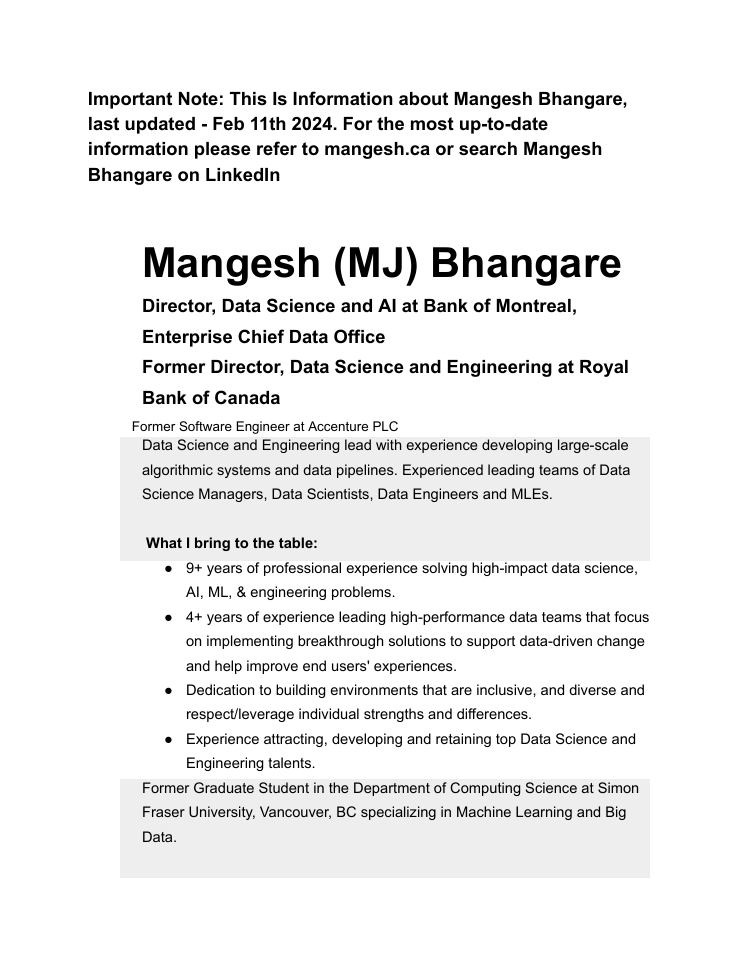

In [ ]:
snap_image = convert_from_path("pdfs/mangesh_Personal.pdf", dpi=88)
snap_image[0]

In [ ]:
!rm -rf "db"

In [ ]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

24

In [ ]:
## Load HuggingFaceInstructEmbeddings

embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

19

In [ ]:
# Using Chroma

%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

CPU times: user 1.32 s, sys: 27.8 ms, total: 1.35 s
Wall time: 1.58 s


In [ ]:
# Using GPTQ Version
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

1. You disabled CUDA extensions compilation by setting BUILD_CUDA_EXT=0 when install auto_gptq from source.
2. You are using pytorch without CUDA support.
3. CUDA and nvcc are not installed in your device.


config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

quantize_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

In [ ]:
#####################################
#                                   #
#  Setting up Default System Prompt #
#                                   #
#####################################

DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} [/INST]
""".strip()

In [ ]:
generate_prompt("Hello, How are you doing?")

"[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n<</SYS>>\n\nHello, How are you doing? [/INST]"

In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [ ]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.1.0+cu121)
    Python  3.10.11 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'Marian

In [ ]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [ ]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

In [ ]:
result = qa_chain("Who is Mangesh Bhangare?")

 Based on the provided context, Mangesh Bhangare is a Director of Data Science and AI at Bank of Montreal's Enterprise Chief Data Office. He has extensive experience in data science, AI, machine learning, and engineering, having worked as a director at Royal Bank of Canada and led high-performance data teams. He specializes in developing large-scale algorithmic systems and data pipelines and is dedicated to creating inclusive and diverse environments. His expertise spans over nine years, and he can be contacted through LinkedIn.


In [ ]:
result = qa_chain("What is Mangesh's Faviorite programming language?")

 Based on the information provided, Mangesh's favorite programming language is Python.


In [ ]:
result = qa_chain("What is his educational background?")

 Based on the provided information, the person's educational background is:

Master of Science (MS) in Computer Science with a specialization in Machine Learning and Big Data from Simon Fraser University in British Columbia, Canada.


In [ ]:
result = qa_chain("How many organization's Mangesh has worked so far?")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 Based on the information provided, Mangesh has worked for three organizations:

1. Accenture PLC
2. Royal Bank of Canada
3. Bank of Montreal


In [ ]:
result = qa_chain("What organization's Mangesh has worked in so far ? And list all of those organization's names with a short description and which sector they belong to?")

 Based on the provided information, here are the organizations that Mangesh has worked for, along with a brief description and their respective sectors:

1. Accenture PLC (Software Consulting)
	* Mangesh worked as a Software Engineer at Accenture PLC.
2. Royal Bank of Canada (Financial Services)
	* Mangesh served as the Director of Data Science and Engineering at Royal Bank of Canada.
3. Bank of Montreal (Financial Services)
	* Currently, Mangesh is the Director of Data Science and AI at Bank of Montreal.

All three organizations are from the financial services sector.


In [ ]:
result = qa_chain("What organization Mangesh has worked in so far? And list all of those organization's names with a short description of the role he performed there, a short description of those organizations and which sector they belong to as well?")

 Based on the information provided, here are the organizations Mangesh has worked for along with a brief description of his roles, the organizations themselves, and their sectors:

1. Accenture PLC (Software Engineer)
	* Description: As a software engineer at Accenture PLC, Mangesh likely worked on developing large-scale algorithmic systems and data pipelines.
	* Organization: Accenture PLC is a multinational professional services company that provides strategy, consulting, digital, technology, and operations services. It operates in the IT industry.
2. Royal Bank of Canada (Director, Data Science and Engineering)
	* Description: As the director of data science and engineering at Royal Bank of Canada, Mangesh led high-performance data teams that focused on implementing breakthrough solutions to support data-driven change and improve end-user experiences.
	* Organization: The Royal Bank of Canada is one of the largest banks in Canada, offering a range of financial products and services 

In [ ]:
result = qa_chain("Which industry sector and domain Mangesh's experiance lie in?")

 Based on the information provided, Mangesh's experience lies in the financial industry sector, specifically in the field of data science and artificial intelligence at a bank.


In [ ]:
result = qa_chain("Where I can find most up-to-date information on Mangesh and what's the best way of contacting him?")

 Based on the provided information, the best way to get the most up-to-date information on Mangesh Bhangare would be to check his LinkedIn profile, as he has mentioned that he updates his profile regularly. His LinkedIn profile can be found at <https://www.linkedin.com/in/mangeshb1/>.

Additionally, if you want to contact Mangesh, he has specified that LinkedIn is his preferred method of communication. You can send him a message through LinkedIn or email him at 

In [ ]:
result = qa_chain("List some of the major project's that Mangesh has worked on in the past?")

 Based on the information provided, here are some of the major projects that Mangesh has worked on in the past:

1. Simulation-Based Credit Card Recommendation Engine: This project used machine learning algorithms to recommend the right credit card products to customers based on their propensity to respond and expected profit.
2. BERT-based NLP/NLU Models: This project used BERT, a powerful natural language processing technique, to identify client frustration through various unstructured text data points.
3. Channel Optimization Model: This project aimed to select the right clients for direct mail marketing campaigns.
4. Call Center Optimization Model: This project predicted which customers were likely to pick up a phone call, helping to optimize call center operations.
